In [1]:
import sympy
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

![Circuit](fig/circuit.png)

Define your variables

In [2]:
R_1, R_2, L, C, I_1, I_2, I_3, U, s, t = sympy.symbols('R_1, R_2, L, C, I_1, I_2, I_3, U, s, t')

Setup your equations based on loop laws.

In [3]:
eq1 = U - R_1*I_1 - (1/C)*(I_1 - I_2)/s
eq1

-I_1*R_1 + U - (I_1 - I_2)/(C*s)

In [4]:
eq2 = R_2*I_2 + L*I_2*s - (1/(C*s))*(I_1 - I_2)
eq2

I_2*L*s + I_2*R_2 - (I_1 - I_2)/(C*s)

Solve your equations.

In [5]:
sol = sympy.solve([eq1, eq2], [I_1, I_2])
sol[I_1]

(C*L*U*s**2 + C*R_2*U*s + U)/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

In [6]:
sol[I_2]

U/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

Find the transfer function for the voltage drop across the inductor.

In [7]:
G = (-L*s*sol[I_2])/U
G

-L*s/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

In [8]:
component_values = {
    R_1: 1,
    R_2: 1,
    L: 1,
    C: sympy.Rational(1, 2)
}

In [9]:
G1 = G.subs(component_values)
G1

-s/(s**2/2 + 3*s/2 + 2)

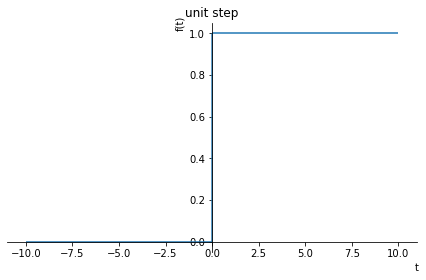

In [10]:
sympy.plot(sympy.Heaviside(t), title='unit step')

In [11]:
g = sympy.inverse_laplace_transform(sympy.apart(G1), s, t)
sympy.Eq(sympy.Function('g')(t), g)

Eq(g(t), 2*(3*sqrt(7)*sin(sqrt(7)*t/2) - 7*cos(sqrt(7)*t/2))*exp(-3*t/2)*Heaviside(t)/7)

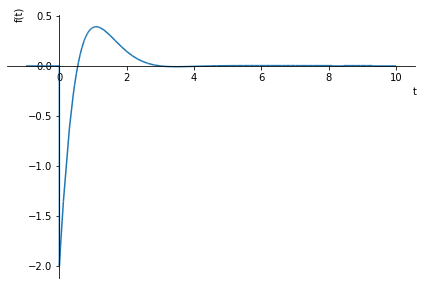

In [12]:
sympy.plot(g, (t, -1, 10))

In [13]:
num, den = sympy.fraction(G1)
sympy.Poly(s**2 + 2*s  +3, s).all_coeffs()

[1, 2, 3]

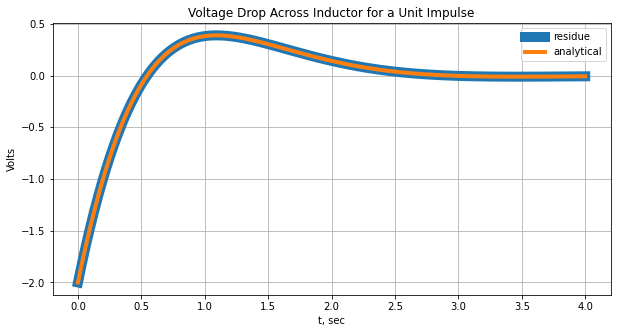

In [14]:
def sympy_vs_numerical():
    t_vals = np.linspace(0, 4, 1000)
    
    dirac_delta = lambda t: scipy.signal.unit_impulse(len(t))
    unit_step = lambda t: np.heaviside(t, 1)
    
    f_eval = sympy.lambdify([t], g, modules = [{
        'Heaviside': unit_step,
        'DiracDelta': dirac_delta,
    }, 'numpy'])

    num, den = sympy.fraction(G1)
    num_coeffs = sympy.Poly(num, s).all_coeffs()
    den_coeffs = sympy.Poly(den, s).all_coeffs()
    
    r, p, k = scipy.signal.residue(num_coeffs, den_coeffs)
    
    y = 0
    
    if len(k) > 0:
        y = k[0]*dirac_delta(t_vals)

    for i in range(len(r)):
        y += r[i]*np.exp(p[i]*t_vals)

    assert np.linalg.norm(np.imag(y)) < 1e-5 # should have small imaginary part
    y = np.real(y)
    plt.figure(figsize=(10, 5))
    plt.plot(t_vals, y, linewidth=10, label='residue')
    plt.plot(t_vals, f_eval(t_vals), linewidth=4, label='analytical')
    plt.grid()
    plt.title('Voltage Drop Across Inductor for a Unit Impulse')
    plt.ylabel('Volts')
    plt.xlabel('t, sec')
    plt.legend()
    
sympy_vs_numerical()

$$ y(t) = \int_0^{t} g(t) u(t - \tau) d\tau$$